In [83]:
import numpy as np
import torch
import torch.nn as nn
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import timm
import matplotlib.pyplot as plt

In [2]:
img = torch.Tensor(np.random.random((4,3,384,384)))
img.shape

torch.Size([4, 3, 384, 384])

In [173]:
class Read_ignore(nn.Module):
    def __init__(self, start_index=1):
        super(Read_ignore, self).__init__()
        self.start_index = start_index

    def forward(self, x):
        return x[:, self.start_index:]


class Read_add(nn.Module):
    def __init__(self, start_index=1):
        super(Read_add, self).__init__()
        self.start_index = start_index

    def forward(self, x):
        if self.start_index == 2:
            readout = (x[:, 0] + x[:, 1]) / 2
        else:
            readout = x[:, 0]
        return x[:, self.start_index :] + readout.unsqueeze(1)


class Read_projection(nn.Module):
    def __init__(self, in_features, start_index=1):
        super(Read_projection, self).__init__()
        self.start_index = start_index
        self.project = nn.Sequential(nn.Linear(2 * in_features, in_features), nn.GELU())

    def forward(self, x):
        readout = x[:, 0].unsqueeze(1).expand_as(x[:, self.start_index :])
        features = torch.cat((x[:, self.start_index :], readout), -1)
        return self.project(features)

In [228]:
class MyConvTranspose2d(nn.Module):
    def __init__(self, conv, output_size):
        super(MyConvTranspose2d, self).__init__()
        self.output_size = output_size
        self.conv = conv

    def forward(self, x):
        x = self.conv(x, output_size=self.output_size)
        return x

class Resample(nn.Module):
    def __init__(self, p, s, h, emb_dim, resample_dim):
        super(Resample, self).__init__()
        self.conv1 = nn.Conv2d(emb_dim,
                               resample_dim, 
                               kernel_size=1,
                               stride=1,
                               padding=0)
        self.conv2 = nn.Identity()
        if s > p:
            self.conv2 = nn.Conv2d(resample_dim,
                                   resample_dim, 
                                   kernel_size=3,
                                   stride=3,
                                   padding=0,
                                   bias=True)
        elif s < p:
            stride = int((h/s)//((h//p)-1))
            print(stride)
            transpose_conv2 = nn.ConvTranspose2d(resample_dim, 
                                resample_dim, 
                                kernel_size=3, 
                                stride=stride,
                                padding=0,
                                bias=True,
                                dilation=1,
                                groups=1)
            self.conv2 = MyConvTranspose2d(transpose_conv2, output_size=(h//s, h//s))


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [229]:
class Reassemble(nn.Module):
    def __init__(self, image_size, read, p, s, emb_dim, resample_dim):
        """
        p = patch size 
        s = coefficient resample
        emb_dim <=> D (in the paper)
        resample_dim <=> ^D (in the paper)
        read : {"ignore", "add", "projection"}
        """
        super(Reassemble, self).__init__()
        channels, image_height, image_width = image_size
        
        #Read
        self.read = Read_ignore()
        if read == 'add':
            self.read = Read_add()
        elif read == 'projection':
            self.read = Read_projection(emb_dim)
    
        #Concat after read
        self.concat = Rearrange('b (h w) c -> b c h w', 
                                c=emb_dim,
                                h=(image_height // p),
                                w=(image_width // p))
        
        #Projection + Resample
        self.resample = Resample(p, s, image_height, emb_dim, resample_dim)
        
    def forward(self, x):
        x = self.read(x)
        x = self.concat(x)
        x = self.resample(x)
        print(x.shape)
        return x

In [230]:
class FocusOnDepth(nn.Module):
    def __init__(self, 
                 image_size = (3, 384, 384), 
                 patch_size = 16, 
                 emb_dim = 1024,
                 resample_dim = 256,
                 read = 'projection',
                 num_layers_encoder = 24,
                 hooks = [5, 11, 17, 23],
                 reassemble_s = [4, 8, 16, 32],
                 nhead = 16,
                 transformer_dropout = 0):
        """
        Focus on Depth - Large
        image_size : (c, h, w)
        patch_size : *a square*
        emb_dim <=> D (in the paper)
        resample_dim <=> ^D (in the paper)
        read : {"ignore", "add", "projection"}
        """
        super().__init__()
        
        #Splitting img into patches
        channels, image_height, image_width = image_size
        assert image_height % patch_size == 0 and image_width % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_height // patch_size) * (image_width // patch_size)
        patch_dim = channels * patch_size * patch_size
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_dim, emb_dim),
        )
        #Embedding
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, emb_dim))
        
        #Transformer
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead, dropout=transformer_dropout, dim_feedforward=emb_dim*4)
        self.transformer_encoders = nn.TransformerEncoder(encoder_layer, num_layers=num_layers_encoder)
        #Register hooks
        self.activation = {}
        self.hooks = hooks
        self._get_layers_from_hooks(self.hooks)
        
        #Reassembles
        self.reassembles = []
        for s in reassemble_s:
            self.reassembles.append(Reassemble(image_size, read, patch_size, s, emb_dim, resample_dim))
    
    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        t = self.transformer_encoders(x)
        for i,(_,v) in enumerate(self.activation.items()):
            self.reassembles[i](v)

    def _get_layers_from_hooks(self, hooks):
        def get_activation(name):
            def hook(model, input, output):
                self.activation[name] = output.detach()
            return hook
        for h in hooks:
            self.transformer_encoders.layers[h].register_forward_hook(get_activation('t'+str(h)))

In [231]:
model = FocusOnDepth((3,384,384), patch_size=16, emb_dim=128, read="projection")
model(img)
#model

4
2
torch.Size([4, 256, 96, 96])


ValueError: requested an output size of (48, 48), but valid sizes range from [49, 49] to [50, 50] (for an input of torch.Size([24, 24]))

In [184]:
model.activation.keys()

dict_keys(['t5', 't11', 't17', 't23'])

torch.Size([1, 576, 768])


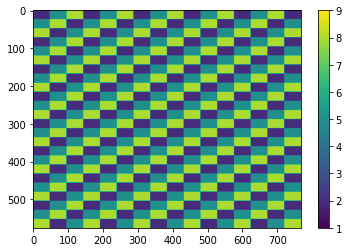

torch.Size([1, 768, 24, 24])


tensor([[[1., 2., 3.,  ..., 1., 2., 3.],
         [4., 5., 6.,  ..., 4., 5., 6.],
         [7., 8., 9.,  ..., 7., 8., 9.],
         ...,
         [1., 2., 3.,  ..., 1., 2., 3.],
         [4., 5., 6.,  ..., 4., 5., 6.],
         [7., 8., 9.,  ..., 7., 8., 9.]],

        [[1., 2., 3.,  ..., 1., 2., 3.],
         [4., 5., 6.,  ..., 4., 5., 6.],
         [7., 8., 9.,  ..., 7., 8., 9.],
         ...,
         [1., 2., 3.,  ..., 1., 2., 3.],
         [4., 5., 6.,  ..., 4., 5., 6.],
         [7., 8., 9.,  ..., 7., 8., 9.]],

        [[1., 2., 3.,  ..., 1., 2., 3.],
         [4., 5., 6.,  ..., 4., 5., 6.],
         [7., 8., 9.,  ..., 7., 8., 9.],
         ...,
         [1., 2., 3.,  ..., 1., 2., 3.],
         [4., 5., 6.,  ..., 4., 5., 6.],
         [7., 8., 9.,  ..., 7., 8., 9.]],

        [[2., 3., 1.,  ..., 2., 3., 1.],
         [5., 6., 4.,  ..., 5., 6., 4.],
         [8., 9., 7.,  ..., 8., 9., 7.],
         ...,
         [2., 3., 1.,  ..., 2., 3., 1.],
         [5., 6., 4.,  ..., 5., 6., 

In [125]:
#Validation des rearrange
tmp = np.array([[1,2,3],[4,5,6],[7,8,9]])
tmp = np.concatenate([np.concatenate([tmp] * 128, axis=1)]*128)
tmp = np.stack([tmp,tmp,tmp], axis=0)
tmp = np.array([tmp])
tmp = torch.Tensor(tmp)
tmp.shape

topatch = Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
tmp2 = topatch(tmp)
tmp2 = torch.Tensor(tmp2)
print(tmp2.shape)
plt.imshow(tmp2[0], aspect='auto')
plt.colorbar()
plt.show()

concat = Rearrange('b (h w) c -> b c h w', c=768, h=(384 // 16), w=(384 // 16))
tmp3 = concat(tmp2)
tmp3 = torch.Tensor(tmp3)
print(tmp3.shape)
tmp3[0,:4]

In [126]:
resample2 = Resample(16, 2, 768, 768)
tmp4 = resample2(tmp3)

In [128]:
print(tmp3.shape)
print(tmp4.shape)

torch.Size([1, 768, 24, 24])
torch.Size([1, 768, 72, 72])


In [181]:
conv2 = nn.ConvTranspose2d(768, 768, 
                        kernel_size=3, 
                        stride=3,
                        padding=0,
                        bias=True,
                        dilation=1,
                        groups=1)

In [182]:
tmp5 = conv2(tmp3)
tmp5.shape

torch.Size([1, 768, 49, 49])